# Baby Cry Detection CNN (PyTorch)

Train a CNN to classify baby cry vs non-cry using log-mel spectrograms with PyTorch.

- Dataset: `Dataset/balanced/cry` and `Dataset/balanced/non-cry`
- Framework: PyTorch + torchaudio/librosa
- Features: Log-Mel Spectrograms

Notes
- This runs on CPU by default; uses CUDA automatically if available.
- Adjust `dataset_root` if your paths differ.

In [32]:
# Section 1: Install and Import Dependencies
# If needed, install packages (run separately in your environment):
# pip install numpy pandas librosa soundfile scikit-learn matplotlib seaborn torch torchvision torchaudio

import os
import sys
import json
import random
from pathlib import Path
from typing import List, Tuple

import numpy as np
import pandas as pd
import librosa
import librosa.display
import soundfile as sf
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
    average_precision_score,
    f1_score,
)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

print('torch', torch.__version__)

torch 2.9.0+cpu


In [33]:
# Section 2: Configure Paths and Hyperparameters
from pathlib import Path
import torch

# Define repository root safely (go one level up from notebooks/)
repo_root = Path(__file__).resolve().parents[1] if '__file__' in globals() else Path.cwd().parents[1]

# Dataset paths
dataset_root = repo_root / "LittleBee" / "Dataset" / "balanced"
cry_dir = dataset_root / "cry"
noncry_dir = dataset_root / "non-cry"

# Output directories
output_dir = repo_root / "models"
fig_dir = repo_root / "notebooks" / "figures"

# Ensure directories exist
output_dir.mkdir(parents=True, exist_ok=True)
fig_dir.mkdir(parents=True, exist_ok=True)

# Audio/feature configuration
SAMPLE_RATE = 16000
DURATION_SECONDS = 5
N_SAMPLES = SAMPLE_RATE * DURATION_SECONDS
N_MELS = 64
FFT = 1024
HOP = 256
TARGET_DB = -20.0

# Training configuration
BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 1e-3
VAL_SPLIT = 0.15
TEST_SPLIT = 0.15
SEED = 42

# Device configuration
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Print summary
print(f"Device: {DEVICE}")
print(f"Dataset root: {dataset_root}")
print(f"Cry dir exists? {cry_dir.exists()}")
print(f"Non-cry dir exists? {noncry_dir.exists()}")
print(f"Figures directory: {fig_dir}")
print(f"Output directory: {output_dir}")


Device: cpu
Dataset root: c:\Users\mkhan\Documents\Projects\Niha\LittleBee\Dataset\balanced
Cry dir exists? True
Non-cry dir exists? True
Figures directory: c:\Users\mkhan\Documents\Projects\Niha\notebooks\figures
Output directory: c:\Users\mkhan\Documents\Projects\Niha\models


In [34]:
# Section 3: Set Deterministic Seeds
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
print('Seeds set.')

Seeds set.


In [35]:
print("CWD:", Path.cwd())
print("Cry dir:", cry_dir.resolve())
print("Non-cry dir:", noncry_dir.resolve())

print("Cry dir exists?", cry_dir.exists())
print("Non-cry dir exists?", noncry_dir.exists())

print("Example cry files:", list(cry_dir.glob('*'))[:5])
print("Example non-cry files:", list(noncry_dir.glob('*'))[:5])


CWD: c:\Users\mkhan\Documents\Projects\Niha\LittleBee\notebooks
Cry dir: C:\Users\mkhan\Documents\Projects\Niha\LittleBee\Dataset\balanced\cry
Non-cry dir: C:\Users\mkhan\Documents\Projects\Niha\LittleBee\Dataset\balanced\non-cry
Cry dir exists? True
Non-cry dir exists? True
Example cry files: [WindowsPath('c:/Users/mkhan/Documents/Projects/Niha/LittleBee/Dataset/balanced/cry/cry_00000.wav'), WindowsPath('c:/Users/mkhan/Documents/Projects/Niha/LittleBee/Dataset/balanced/cry/cry_00001.wav'), WindowsPath('c:/Users/mkhan/Documents/Projects/Niha/LittleBee/Dataset/balanced/cry/cry_00002.wav'), WindowsPath('c:/Users/mkhan/Documents/Projects/Niha/LittleBee/Dataset/balanced/cry/cry_00003.wav'), WindowsPath('c:/Users/mkhan/Documents/Projects/Niha/LittleBee/Dataset/balanced/cry/cry_00004.wav')]
Example non-cry files: [WindowsPath('c:/Users/mkhan/Documents/Projects/Niha/LittleBee/Dataset/balanced/non-cry/noncry_00000.wav'), WindowsPath('c:/Users/mkhan/Documents/Projects/Niha/LittleBee/Dataset/bal

In [36]:
# Section 4: Index Dataset

def list_audio_files(dir_path: Path, exts=(".wav", ".mp3", ".flac", ".ogg")) -> List[Path]:
    if not dir_path.exists():
        return []
    files = []
    for ext in exts:
        files.extend(dir_path.rglob(f"*{ext}"))
    return sorted(files)

cry_files = list_audio_files(cry_dir)
noncry_files = list_audio_files(noncry_dir)
print(f"Found {len(cry_files)} cry files, {len(noncry_files)} non-cry files")

rows = []
for p in cry_files:
    rows.append({"filepath": str(p), "label": 1})
for p in noncry_files:
    rows.append({"filepath": str(p), "label": 0})

df = pd.DataFrame(rows)

if df.empty:
    raise RuntimeError(
        f"No audio files found. Checked: cry={cry_dir}, non-cry={noncry_dir}. "
        "Verify dataset_root path and supported extensions (.wav, .mp3, .flac, .ogg)."
    )

print('First rows:')
print(df.head())
print('Class distribution:', df['label'].value_counts().to_dict())

# Quick duration check on a few files (use librosa with soundfile fallback for mp3 compatibility)
for fp in df.sample(min(10, len(df)), random_state=SEED).filepath:
    try:
        dur = librosa.get_duration(path=fp)
        print(Path(fp).name, 'duration(s)=', round(float(dur), 2))
    except Exception:
        try:
            info = sf.info(fp)
            print(Path(fp).name, 'duration(s)=', round(float(info.duration), 2))
        except Exception as e2:
            print('Could not read', fp, e2)

Found 1450 cry files, 324 non-cry files
First rows:
                                            filepath  label
0  c:\Users\mkhan\Documents\Projects\Niha\LittleB...      1
1  c:\Users\mkhan\Documents\Projects\Niha\LittleB...      1
2  c:\Users\mkhan\Documents\Projects\Niha\LittleB...      1
3  c:\Users\mkhan\Documents\Projects\Niha\LittleB...      1
4  c:\Users\mkhan\Documents\Projects\Niha\LittleB...      1
Class distribution: {1: 1450, 0: 324}
cry_00999.wav duration(s)= 7.0
cry_00596.wav duration(s)= 7.0
cry_01132.wav duration(s)= 7.0
cry_00270.wav duration(s)= 7.0
cry_00414.wav duration(s)= 7.0
cry_00771.wav duration(s)= 7.0
cry_00530.wav duration(s)= 7.0
cry_00978.wav duration(s)= 7.0
noncry_00116.wav duration(s)= 7.0
noncry_00017.wav duration(s)= 7.0


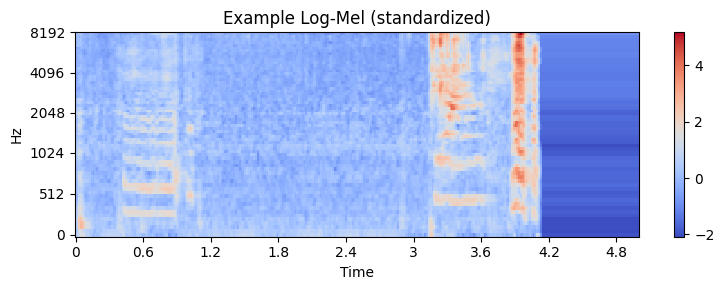

In [37]:
# Section 5: Audio Preprocessing and Log-Mel

def load_and_preprocess_waveform(path: str,
                                 sr: int = SAMPLE_RATE,
                                 duration_s: float = DURATION_SECONDS,
                                 target_db: float = TARGET_DB) -> np.ndarray:
    y, _ = librosa.load(path, sr=sr, mono=True)
    yt, _ = librosa.effects.trim(y, top_db=30)
    target_len = int(sr * duration_s)
    if len(yt) < target_len:
        yt = np.pad(yt, (0, target_len - len(yt)), mode='constant')
    else:
        yt = yt[:target_len]
    rms = np.sqrt(np.mean(yt**2) + 1e-9)
    rms_db = 20 * np.log10(rms + 1e-9)
    gain_db = target_db - rms_db
    yt = yt * (10 ** (gain_db / 20))
    peak = np.max(np.abs(yt)) + 1e-9
    if peak > 1.0:
        yt = yt / peak
    return yt.astype(np.float32)

def waveform_to_logmel(y: np.ndarray,
                        sr: int = SAMPLE_RATE,
                        n_fft: int = FFT,
                        hop_length: int = HOP,
                        n_mels: int = N_MELS) -> np.ndarray:
    S = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, power=2.0
    )
    S_db = librosa.power_to_db(S, ref=np.max)
    mu = S_db.mean(axis=1, keepdims=True)
    std = S_db.std(axis=1, keepdims=True) + 1e-6
    S_std = (S_db - mu) / std
    return S_std.astype(np.float32)

# Visualize example
if len(df) > 0:
    ex_fp = df.sample(1, random_state=SEED).iloc[0]['filepath']
    y = load_and_preprocess_waveform(ex_fp)
    M = waveform_to_logmel(y)
    plt.figure(figsize=(8, 3))
    librosa.display.specshow(M, sr=SAMPLE_RATE, hop_length=HOP, x_axis='time', y_axis='mel')
    plt.title('Example Log-Mel (standardized)')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

In [38]:
# Section 6: Splits
labels = df['label'].values
filepaths = df['filepath'].values

fp_trainval, fp_test, y_trainval, y_test = train_test_split(
    filepaths, labels, test_size=TEST_SPLIT, random_state=SEED, stratify=labels
)
val_ratio = VAL_SPLIT / (1.0 - TEST_SPLIT)
fp_train, fp_val, y_train, y_val = train_test_split(
    fp_trainval, y_trainval, test_size=val_ratio, random_state=SEED, stratify=y_trainval
)
print(f"Train: {len(fp_train)}  Val: {len(fp_val)}  Test: {len(fp_test)}")

splits = {
    'train': { 'filepaths': fp_train.tolist(), 'labels': y_train.tolist() },
    'val':   { 'filepaths': fp_val.tolist(),   'labels': y_val.tolist()   },
    'test':  { 'filepaths': fp_test.tolist(),  'labels': y_test.tolist()  },
}
with open(output_dir / 'splits_torch.json', 'w') as f:
    json.dump(splits, f, indent=2)

Train: 1241  Val: 266  Test: 267


In [39]:
# Section 7: Torch Dataset and DataLoader

class CryDataset(Dataset):
    def __init__(self, filepaths: List[str], labels: List[int], augment: bool = False):
        self.filepaths = filepaths
        self.labels = labels
        self.augment = augment

    def __len__(self):
        return len(self.filepaths)

    def _augment(self, y: np.ndarray) -> np.ndarray:
        # Simple augmentations
        if random.random() < 0.5:
            gain_db = random.uniform(-6, 6)
            y = y * (10 ** (gain_db / 20))
        if random.random() < 0.5:
            max_shift = int(0.2 * SAMPLE_RATE)
            shift = random.randint(-max_shift, max_shift)
            y = np.roll(y, shift)
        if random.random() < 0.5:
            noise_level = random.uniform(0.001, 0.01)
            y = y + np.random.randn(*y.shape).astype(np.float32) * noise_level
        y = np.clip(y, -1.0, 1.0)
        return y

    def __getitem__(self, idx):
        fp = self.filepaths[idx]
        label = self.labels[idx]
        y = load_and_preprocess_waveform(fp)
        if self.augment:
            y = self._augment(y)
        M = waveform_to_logmel(y)
        # To tensor: (1, n_mels, time)
        M = torch.tensor(M, dtype=torch.float32)
        M = M.unsqueeze(0)
        return M, torch.tensor(label, dtype=torch.float32)

train_ds = CryDataset(fp_train.tolist(), y_train.tolist(), augment=True)
val_ds = CryDataset(fp_val.tolist(), y_val.tolist(), augment=False)
test_ds_torch = CryDataset(fp_test.tolist(), y_test.tolist(), augment=False)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_ds_torch, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

xb, yb = next(iter(train_loader))
print('Batch shapes:', xb.shape, yb.shape)  # [B,1,N_MELS,T], [B]

Batch shapes: torch.Size([32, 1, 64, 313]) torch.Size([32])


In [40]:
# Section 8: Model Definition

class CNNBabyCry(nn.Module):
    def __init__(self):
        super().__init__()
        # Input (B,1,N_MELS,T)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.dropout = nn.Dropout(0.3)
        self.pool = nn.MaxPool2d(2)
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(128, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout(x)
        x = self.gap(x).squeeze(-1).squeeze(-1)  # (B, C)
        x = self.fc(x)
        return x.view(-1)

model = CNNBabyCry().to(DEVICE)
print(model)

CNNBabyCry(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (gap): AdaptiveAvgPool2d(output_size=1)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


In [41]:
# Section 9: Optimizer, Scheduler, Training Utils

pos_weight = None
# Optional: compute pos_weight for BCEWithLogitsLoss if class imbalance severe
num_pos = int((np.array(y_train) == 1).sum())
num_neg = int((np.array(y_train) == 0).sum())
if num_pos > 0 and num_neg > 0:
    pos_weight = torch.tensor([num_neg / max(num_pos, 1)], device=DEVICE, dtype=torch.float32)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight) if pos_weight is not None else nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
# Remove 'verbose' for compatibility with older PyTorch versions
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

best_val_auc = -np.inf
ckpt_path = output_dir / 'cnn_baby_cry_torch.pt'

def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for xb, yb in loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * xb.size(0)
    return running_loss / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    all_probs = []
    all_targets = []
    running_loss = 0.0
    for xb, yb in loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        logits = model(xb)
        loss = criterion(logits, yb)
        probs = torch.sigmoid(logits)
        all_probs.append(probs.detach().cpu().numpy())
        all_targets.append(yb.detach().cpu().numpy())
        running_loss += loss.item() * xb.size(0)
    all_probs = np.concatenate(all_probs)
    all_targets = np.concatenate(all_targets).astype(int)
    auc = roc_auc_score(all_targets, all_probs) if len(np.unique(all_targets)) > 1 else 0.0
    return running_loss / len(loader.dataset), auc, all_probs, all_targets

In [42]:
# Section 10: Training Loop with Early Stopping

patience = 7
no_improve = 0
history = {'train_loss': [], 'val_loss': [], 'val_auc': []}

for epoch in range(1, EPOCHS + 1):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_auc, _, _ = evaluate(model, val_loader)

    # Log LR reduce events manually (since some torch versions don't support verbose in scheduler)
    prev_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_loss)
    new_lr = optimizer.param_groups[0]['lr']
    if new_lr < prev_lr:
        print(f"  LR reduced: {prev_lr:.6g} -> {new_lr:.6g}")

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_auc'].append(val_auc)

    print(f"Epoch {epoch:03d} | train_loss={train_loss:.4f} | val_loss={val_loss:.4f} | val_auc={val_auc:.4f}")

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        no_improve = 0
        torch.save({'model_state': model.state_dict(), 'config': {
            'SAMPLE_RATE': SAMPLE_RATE,
            'DURATION_SECONDS': DURATION_SECONDS,
            'N_MELS': N_MELS,
            'FFT': FFT,
            'HOP': HOP,
            'TARGET_DB': TARGET_DB,
        }}, ckpt_path)
        print('  Saved checkpoint ->', ckpt_path)
    else:
        no_improve += 1
        if no_improve >= patience:
            print('Early stopping triggered.')
            break

# Plot curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history['train_loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.title('Loss'); plt.legend()
plt.subplot(1,2,2)
plt.plot(history['val_auc'], label='val AUC')
plt.title('Validation AUC'); plt.legend()
plt.tight_layout()
plt.savefig(fig_dir / 'training_curves_torch.png', dpi=120)
plt.show()

Epoch 001 | train_loss=0.2053 | val_loss=0.4025 | val_auc=0.8599
  Saved checkpoint -> c:\Users\mkhan\Documents\Projects\Niha\models\cnn_baby_cry_torch.pt
Epoch 002 | train_loss=0.1755 | val_loss=0.1635 | val_auc=0.8671
  Saved checkpoint -> c:\Users\mkhan\Documents\Projects\Niha\models\cnn_baby_cry_torch.pt
Epoch 002 | train_loss=0.1755 | val_loss=0.1635 | val_auc=0.8671
  Saved checkpoint -> c:\Users\mkhan\Documents\Projects\Niha\models\cnn_baby_cry_torch.pt
Epoch 003 | train_loss=0.1694 | val_loss=0.1611 | val_auc=0.8807
  Saved checkpoint -> c:\Users\mkhan\Documents\Projects\Niha\models\cnn_baby_cry_torch.pt
Epoch 003 | train_loss=0.1694 | val_loss=0.1611 | val_auc=0.8807
  Saved checkpoint -> c:\Users\mkhan\Documents\Projects\Niha\models\cnn_baby_cry_torch.pt
Epoch 004 | train_loss=0.1595 | val_loss=0.1491 | val_auc=0.8774
Epoch 004 | train_loss=0.1595 | val_loss=0.1491 | val_auc=0.8774


KeyboardInterrupt: 

In [ ]:
# Section 11: Evaluation on Test Set

# Load best checkpoint
ckpt = torch.load(ckpt_path, map_location=DEVICE)
model.load_state_dict(ckpt['model_state'])
model.eval()

with torch.no_grad():
    test_loss, test_auc, test_probs, test_targets = evaluate(model, test_loader)

print('Test ROC AUC:', test_auc)

# Default threshold 0.5
preds = (test_probs >= 0.5).astype(int)
print('Accuracy:', (preds == test_targets).mean())
print(classification_report(test_targets, preds, target_names=['non-cry','cry']))

cm = confusion_matrix(test_targets, preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['non-cry','cry'], yticklabels=['non-cry','cry'])
plt.title('Confusion Matrix (thr=0.5)')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.tight_layout()
plt.savefig(fig_dir / 'confusion_matrix_torch.png', dpi=120)
plt.show()

# ROC/PR curves
fpr, tpr, _ = roc_curve(test_targets, test_probs)
plt.figure(); plt.plot(fpr, tpr, label=f'AUC={roc_auc_score(test_targets, test_probs):.3f}')
plt.plot([0,1],[0,1],'k--'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC'); plt.legend(); plt.tight_layout();
plt.savefig(fig_dir / 'roc_curve_torch.png', dpi=120)
plt.show()

prec, rec, _ = precision_recall_curve(test_targets, test_probs)
plt.figure(); plt.plot(rec, prec, label=f'AP={average_precision_score(test_targets, test_probs):.3f}')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('PR'); plt.legend(); plt.tight_layout();
plt.savefig(fig_dir / 'pr_curve_torch.png', dpi=120)
plt.show()

In [ ]:
# Section 12: Threshold Tuning and Save Assets

thresholds = np.linspace(0, 1, 201)
best = max(((t, f1_score(test_targets, (test_probs >= t).astype(int))) for t in thresholds), key=lambda x: x[1])
best_t, best_f1 = best
print(f'Best threshold: {best_t:.3f}  F1={best_f1:.3f}')

plt.figure(); plt.plot(thresholds, [f1_score(test_targets, (test_probs >= t).astype(int)) for t in thresholds])
plt.axvline(best_t, color='r', linestyle='--'); plt.xlabel('Threshold'); plt.ylabel('F1'); plt.title('Threshold Tuning'); plt.tight_layout();
plt.savefig(fig_dir / 'threshold_tuning_torch.png', dpi=120)
plt.show()

# Save threshold and label map
with open(output_dir / 'threshold_torch.json', 'w') as f:
    json.dump({'threshold': float(best_t)}, f, indent=2)
with open(output_dir / 'labels.json', 'w') as f:
    json.dump({'0': 'non-cry', '1': 'cry'}, f, indent=2)

print('Saved threshold and labels map to', output_dir)

In [ ]:
# Section 13: Inference Utility

def load_model_for_inference(ckpt_path: Path) -> nn.Module:
    m = CNNBabyCry().to(DEVICE)
    state = torch.load(ckpt_path, map_location=DEVICE)
    m.load_state_dict(state['model_state'])
    m.eval()
    return m

@torch.no_grad()
def predict_file(filepath: str, model: nn.Module, threshold: float = 0.5):
    y = load_and_preprocess_waveform(filepath)
    M = waveform_to_logmel(y)
    ten = torch.tensor(M, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(DEVICE)  # (1,1,N_MELS,T)
    logits = model(ten)
    prob = torch.sigmoid(logits).item()
    label = int(prob >= threshold)
    return label, prob

# Example usage:
# m = load_model_for_inference(ckpt_path)
# with open(output_dir / 'threshold_torch.json') as f: thr = json.load(f)['threshold']
# fp = splits['test']['filepaths'][0]; lbl, pr = predict_file(fp, m, thr); print(lbl, pr)